In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50

import json
from glob import glob

In [3]:
torch.backends.cudnn.benchmark=True

## Data

In [4]:
PATH = Path('../data/Train')

In [5]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [6]:
VEHICLES=10
ROADS=7
ROAD_LINES=6

In [7]:
S_PREFIX = 'tb-crop'

### Create dataloader

In [8]:
def convert_y(y_img):
    y_new = np.zeros(y_img.shape, dtype=int)
    y_new[y_img[:,:,2]==VEHICLES] = 1
    # yv = y_img[:,:,2]==VEHICLES
    cutoff_y = int(y_new.shape[0]*.83)
    y_new[cutoff_y:,:,:] = 0

    y_new[y_img[:,:,2]==ROADS] = 2
    y_new[y_img[:,:,2]==ROAD_LINES] = 2
#     print(np.mean(y_new))
    return y_new

In [9]:
def open_y_image(fn):
    """ Opens an image using OpenCV given the file path.

    Arguments:
        fn: the file path of the image

    Returns:
        The image in RGB format as numpy array of floats normalized to range between 0.0 - 1.0
    """
    flags = cv2.IMREAD_UNCHANGED+cv2.IMREAD_ANYDEPTH+cv2.IMREAD_ANYCOLOR
    if not os.path.exists(fn):
        raise OSError('No such file or directory: {}'.format(fn))
    elif os.path.isdir(fn):
        raise OSError('Is a directory: {}'.format(fn))
    else:
        try:
            im = cv2.imread(str(fn), flags)
            if im is None: raise OSError(f'File not recognized by opencv: {fn}')
#             return im
            return convert_y(im)
        except Exception as e:
            raise OSError('Error handling image at: {}'.format(fn)) from e

In [10]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): 
        return open_y_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 2
#     def get(self, tfm, x, y):
#         x,y = super().get(tfm, x, y)
#         print(y.shape)
#         return x,y

In [11]:
def crop_bg(x, y):
#     print(x.shape)
    # Original
    h = x.shape[0]
    top = int(h/3.75)
    bot = int(h*.9 + h/150)
    x,y = x[top:bot,:,:],y[top:bot,:,:]
#     print(y.shape)
    return x,y
    

In [13]:

class RC(CoordTransform):
    """ A class that represents a Random Crop transformation.

    This transforms (optionally) transforms x,y at with the same parameters.
    Arguments
    ---------
        targ: int
            target size of the crop.
        tfm_y: TfmType
            type of y transformation.
    """
    def __init__(self, targ_sz, tfm_y=TfmType.NO, sz_y=None):
        super().__init__(tfm_y)
        self.targ_sz,self.sz_y = targ_sz,sz_y

    def set_state(self):
        self.store.rand_r = random.uniform(0, 1)
        self.store.rand_c = random.uniform(0, 1)

    def do_transform(self, x, is_y):
#         print('RC pre:', x.shape)
        r,c,*_ = x.shape
        sz = self.sz_y if is_y else self.targ_sz
        start_r = np.floor(self.store.rand_r*(r-sz)).astype(int)
        start_c = np.floor(self.store.rand_c*(c-sz)).astype(int)
        res = crop(x, start_r, start_c, sz)
        return res

In [14]:
x_names_val = np.array(glob(str(PATH/'AnswersRGB'/'*.png')))
y_names_val = np.array(glob(str(PATH/'AnswersSeg'/'*.png')))

In [15]:
def get_data(train_path, mask_path, bs, size):
    x_names = np.array(glob(str(PATH/TRAIN_DN/'*.png')))
    y_names = np.array(glob(str(PATH/MASKS_DN/'*.png')))
    x_names_val = np.array(glob(str(PATH/'AnswersRGB'/'*.png')))
    y_names_val = np.array(glob(str(PATH/'AnswersSeg'/'*.png')))
    val_idxs = list(range(100))
    val_x,val_y = x_names_val, y_names_val
    trn_x,trn_y = x_names, y_names
#     ((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)
    aug_tfms = [
        crop_bg,
        RandomScale(sz, 1.1, tfm_y=TfmType.CLASS, sz_y=sz),
#         RC(sz, tfm_y=TfmType.CLASS, sz_y=sz),
        RandomRotate(4, tfm_y=TfmType.CLASS),
        RandomFlip(tfm_y=TfmType.CLASS),
        RandomLighting(0.05, 0.1, tfm_y=TfmType.CLASS)
    ]
    tfms = tfms_from_model(resnet34, size, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms, scale=[])
    datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path='')
    md = ImageData(PATH, datasets, bs, num_workers=7, classes=None)
#     del md.trn_ds.transform.tfms[-3]
#     del md.val_ds.transform.tfms[-3]
    md.val_ds.transform.tfms.insert(0, crop_bg)
    denorm = md.trn_ds.denorm
    return md

In [16]:
TRAIN_DN = 'CameraRGB-150'
MASKS_DN = 'CameraSeg-150'
sz = 96
targ_sz = 96
bs = 2
md = get_data(TRAIN_DN, MASKS_DN, bs, sz)

In [17]:
md.trn_ds.transform

[<function crop_bg at 0x7fc68e1390d0>, <fastai.transforms.RandomScale object at 0x7fc62fc11828>, <fastai.transforms.RandomRotate object at 0x7fc62fc11978>, <fastai.transforms.RandomFlip object at 0x7fc62fc11160>, <fastai.transforms.RandomLighting object at 0x7fc62fc11898>, <fastai.transforms.NoCrop object at 0x7fc62fc113c8>, <fastai.transforms.Normalize object at 0x7fc62fc11208>, <fastai.transforms.ChannelOrder object at 0x7fc62fc112e8>]

In [18]:
md.val_ds.transform

[<function crop_bg at 0x7fc68e1390d0>, <fastai.transforms.NoCrop object at 0x7fc62fc11390>, <fastai.transforms.Normalize object at 0x7fc62fc11208>, <fastai.transforms.ChannelOrder object at 0x7fc62fc112b0>]

In [19]:
it = iter(md.val_dl)

In [20]:
y_img = cv2.imread(y_names_val[0])

In [21]:
np.mean(y_img[:,:,2]==7)

0.20628958333333333

In [22]:
x,y = next(it)

In [23]:
x.shape, y.shape

(torch.Size([2, 3, 96, 96]), torch.Size([2, 96, 96]))

In [24]:
np.mean(y[0])

0.7022569444444444

In [25]:
x_names = np.array(glob(str(PATH/TRAIN_DN/'*.png')))

In [26]:
plt.imread(x_names[0])

array([[[0.61176, 0.5451 , 0.47059],
        [0.62745, 0.56078, 0.47843],
        [0.64706, 0.57647, 0.48627],
        ...,
        [0.71373, 0.63137, 0.5098 ],
        [0.74118, 0.6549 , 0.52549],
        [0.74902, 0.66275, 0.53333]],

       [[0.62353, 0.55294, 0.47843],
        [0.63529, 0.56471, 0.47843],
        [0.6549 , 0.58039, 0.4902 ],
        ...,
        [0.71373, 0.63529, 0.51373],
        [0.73333, 0.6549 , 0.52157],
        [0.74118, 0.6549 , 0.52549]],

       [[0.62745, 0.56078, 0.47843],
        [0.64706, 0.57647, 0.4902 ],
        [0.66275, 0.58824, 0.49412],
        ...,
        [0.71373, 0.63137, 0.5098 ],
        [0.72157, 0.63922, 0.51373],
        [0.71373, 0.63137, 0.5098 ]],

       ...,

       [[0.18039, 0.1098 , 0.05098],
        [0.19608, 0.13333, 0.05098],
        [0.21961, 0.14902, 0.08627],
        ...,
        [0.18039, 0.1098 , 0.05098],
        [0.18039, 0.1098 , 0.05098],
        [0.13333, 0.08627, 0.     ]],

       [[0.19608, 0.13333, 0.05098],
  

In [27]:
def new_acc(preds, targs):
    mx,idx = torch.max(preds, 1)
    return (idx == targs).float().mean()
def dice_mult(pred, targs):
#     pred = (pred>0).float()
    mx,idx = torch.max(pred, 1)
    pred = idx.float()
    targs = targs.float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()
def dice(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

## Simple upsample

In [28]:
f = resnet34
cut,lr_cut = model_meta[f]

In [29]:
def get_base():
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers)

## U-net (ish)

In [30]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [31]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p, inplace=True))

In [32]:
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = UnetBlock(256,3,16)
        self.up6 = nn.ConvTranspose2d(16, 3, 1)
        
    def forward(self,x):
        inp = x
        x = F.relu(self.rn(x), inplace=True)
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x, inp)
        x = self.up6(x)
        return torch.squeeze(x)
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [33]:
class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

In [34]:
def get_learner(md):
    m_base = get_base()
    m = to_gpu(Unet34(m_base))
    models = UnetModel(m)
    learn = ConvLearner(md, models)
    learn.opt_fn=optim.Adam
    learn.crit=nn.CrossEntropyLoss()
#     learn.crit = nn.BCEWithLogitsLoss()
    learn.metrics=[new_acc, dice_mult]
    return learn

In [35]:
TRAIN_DN = 'CameraRGB-150'
MASKS_DN = 'CameraSeg-150'
sz = 96
bs = 64

In [36]:
md = get_data(TRAIN_DN, MASKS_DN, bs, sz)

In [37]:
learn = get_learner(md)

In [38]:
x,y = next(iter(md.trn_dl))

In [39]:
learn.freeze_to(1)

### Loading from train6 model

In [69]:
learn.load('600urn-multi')

epoch      trn_loss   val_loss   new_acc    dice_mult     
    0      2.575637   6.808863293528125e+24 0.020945   0.79873   



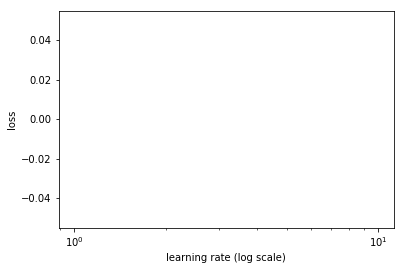

In [70]:
learn.lr_find()
learn.sched.plot()

In [71]:
lr=4e-2
# lr=4e-3
wd=1e-7

lrs = np.array([lr/200,lr/20,lr])/2

In [72]:
learn.fit(lr,1,wds=wd,cycle_len=15,use_clr=(5,8))

epoch      trn_loss   val_loss   new_acc    dice_mult      
    0      0.431295   0.153588   0.936397   1.864358  
    1      0.227489   0.07668    0.972786   1.918992       
    2      0.153719   0.054009   0.98082    1.939807       
    3      0.115895   0.052805   0.981326   1.93864        
    4      0.093062   0.04953    0.982303   1.943962        
    5      0.078096   0.049324   0.982237   1.939886        
    6      0.067883   0.048111   0.983995   1.941416        
    7      0.0607     0.048542   0.983572   1.941366        
    8      0.055022   0.049799   0.982599   1.939057        
    9      0.050674   0.050466   0.982436   1.93794         
    10     0.047104   0.045401   0.98423    1.943687        
    11     0.044587   0.04835    0.983467   1.9406          
    12     0.042462   0.046291   0.984238   1.942265        
    13     0.040562   0.047114   0.983785   1.941198        
    14     0.039139   0.050865   0.982773   1.93818         



[array([0.05087]), 0.982772707939148, 1.9381802894069462]

In [73]:
learn.save(f'128urn-{S_PREFIX}-tmp')

In [74]:
learn.load(f'128urn-{S_PREFIX}-tmp')

In [75]:
learn.unfreeze()
learn.bn_freeze(True)

In [76]:
learn.fit(lrs/2, 1, wds=wd, cycle_len=10,use_clr=(20,10))

epoch      trn_loss   val_loss   new_acc    dice_mult       
    0      0.035456   0.049336   0.983485   1.939127  
    1      0.034803   0.051191   0.982899   1.938067        
    2      0.034166   0.049832   0.983239   1.938929        
    3      0.033688   0.048026   0.983811   1.940253        
    4      0.033343   0.04799    0.984042   1.940987        
    5      0.032824   0.048745   0.983789   1.940335        
    6      0.032318   0.048491   0.984205   1.941367        
    7      0.031823   0.048182   0.984216   1.941521        
    8      0.031416   0.048001   0.984375   1.941652        
    9      0.031171   0.047952   0.984245   1.941361        



[array([0.04795]), 0.9842447638511658, 1.9413614160293302]

In [77]:
learn.fit(lrs/2, 1, wds=wd, cycle_len=10,use_clr=(20,10))

epoch      trn_loss   val_loss   new_acc    dice_mult       
    0      0.031384   0.052269   0.982932   1.937548  
    1      0.031642   0.050131   0.983543   1.939845        
    2      0.031152   0.048911   0.984129   1.940915        
    3      0.030709   0.051235   0.98337    1.938602        
    4      0.030437   0.050849   0.983142   1.938204        
    5      0.030162   0.050865   0.983402   1.939522        
    6      0.029963   0.047732   0.984191   1.941511        
    7      0.02973    0.048163   0.984509   1.942169        
    8      0.029538   0.04921    0.984129   1.94055         
    9      0.029251   0.049319   0.984238   1.940776        



[array([0.04932]), 0.984237551689148, 1.940775876857391]

In [78]:
learn.save(f'128urn-{S_PREFIX}-0')

In [79]:
learn.load(f'128urn-{S_PREFIX}-0')

In [80]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [81]:
py = np.argmax(py,1)

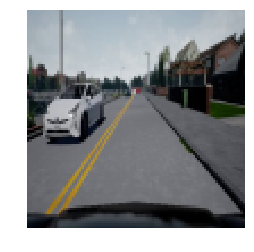

In [82]:
show_img(md.trn_ds.denorm(x)[0])

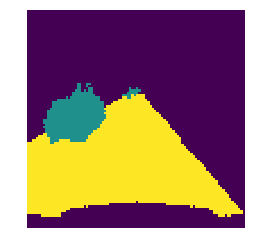

In [83]:
show_img(py[0]);

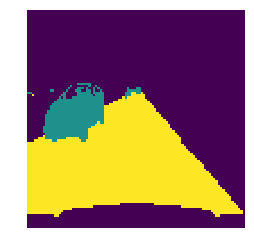

In [84]:
show_img(y[0]);

## 256x256

In [85]:
TRAIN_DN = 'CameraRGB-300'
MASKS_DN = 'CameraSeg-300'
sz=192
bs=64

In [86]:
md = get_data(TRAIN_DN, MASKS_DN, bs, sz)

In [87]:
lr=2e-2
wd=1e-7

lrs = np.array([lr/200,lr/20,lr])/2

In [88]:
learn = get_learner(md)

In [89]:
learn.freeze_to(1)

In [90]:
learn.load(f'128urn-{S_PREFIX}-0')

In [91]:
learn.fit(lr,1,wds=wd, cycle_len=10,use_clr=(5,5))

epoch      trn_loss   val_loss   new_acc    dice_mult       
    0      0.03916    0.062551   0.982232   1.935889  
    1      0.034296   0.048795   0.985768   1.94763         
    2      0.031561   0.051675   0.984363   1.942854        
    3      0.029381   0.050723   0.984519   1.942354        
    4      0.027572   0.05231    0.984888   1.946057        
    5      0.026083   0.048107   0.986245   1.946805        
    6      0.024958   0.046029   0.986653   1.94792         
    7      0.024082   0.054205   0.984148   1.941837        
    8      0.02338    0.048461   0.98663    1.947264        
    9      0.022711   0.049071   0.986026   1.945104        



[array([0.04907]), 0.9860261082649231, 1.9451038242822036]

In [92]:
learn.save(f'256urn-{S_PREFIX}-tmp')

In [93]:
learn.unfreeze()
learn.bn_freeze(True)

In [94]:
learn.load(f'256urn-{S_PREFIX}-tmp')

In [95]:
learn.fit(lrs/2,1,wds=wd, cycle_len=8,use_clr=(20,8))

epoch      trn_loss   val_loss   new_acc    dice_mult       
    0      0.020352   0.050915   0.986106   1.945417  
    1      0.020078   0.048618   0.986277   1.946005        
    2      0.019831   0.050849   0.986284   1.946669        
    3      0.019768   0.050387   0.986199   1.94602         
    4      0.019568   0.048523   0.986687   1.947563        
    5      0.019377   0.049167   0.986658   1.947275        
    6      0.019261   0.050002   0.986609   1.946955        
    7      0.019129   0.049391   0.986755   1.947234        



[array([0.04939]), 0.9867548942565918, 1.9472342915859995]

In [96]:
learn.fit(lrs/2,1,wds=wd, cycle_len=8,use_clr=(20,8))

epoch      trn_loss   val_loss   new_acc    dice_mult       
    0      0.018877   0.04779    0.987561   1.949443  
    1      0.018964   0.050968   0.986202   1.945898        
    2      0.018901   0.052272   0.9859     1.94536         
    3      0.018836   0.051016   0.98649    1.947845        
    4      0.018728   0.050556   0.98648    1.947017        
    5      0.018589   0.049529   0.986924   1.948765        
    6      0.018469   0.050346   0.986852   1.947634        
    7      0.018389   0.050381   0.986722   1.947204        



[array([0.05038]), 0.9867223501205444, 1.9472044003819435]

In [97]:
learn.save(f'256urn-{S_PREFIX}')

In [98]:
learn.load(f'256urn-{S_PREFIX}')

In [99]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [100]:
py = np.argmax(py,1)

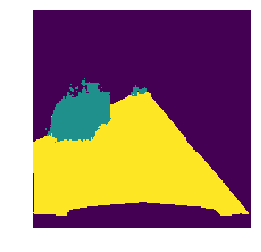

In [101]:
show_img(py[0]);

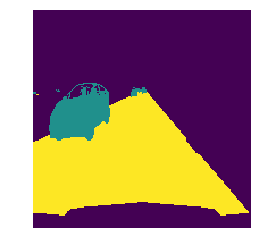

In [102]:
show_img(y[0]);

In [103]:
m.close()

NameError: name 'm' is not defined

## 512x512

In [40]:
TRAIN_DN = 'CameraRGB'
MASKS_DN = 'CameraSeg'
sz=288
bs=16

In [41]:
md = get_data(TRAIN_DN, MASKS_DN, bs, sz)

In [42]:
learn = get_learner(md)

In [43]:
learn.load(f'256urn-{S_PREFIX}')

In [44]:
learn.freeze_to(1)

In [45]:
lr=4e-2
wd=1e-7

lrs = np.array([lr/200,lr/20,lr])/2

In [46]:
learn.fit(lr,1, wds=wd, cycle_len=4,use_clr=(5,4))

epoch      trn_loss   val_loss   new_acc    dice_mult       
    0      0.025417   0.080098   0.976346   1.923702  
    1      0.025859   0.054352   0.986171   1.94696         
    2      0.02117    0.049638   0.986904   1.95174         
    3      0.018806   0.045305   0.988915   1.952278        



[array([0.0453]), 0.9889150182406108, 1.9522776012764065]

In [47]:
learn.save(f'600urn-{S_PREFIX}-tmp')

In [48]:
learn.load(f'600urn-{S_PREFIX}-tmp')

In [49]:
learn.unfreeze()
learn.bn_freeze(True)

In [50]:
lrs = np.array([lr/200,lr/30,lr])

In [51]:
learn.fit(lrs/10,1, wds=wd,cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   new_acc    dice_mult       
    0      0.016377   0.048087   0.988555   1.952228  
    1      0.016112   0.047791   0.988172   1.951711        
    2      0.015772   0.046932   0.988981   1.952641        
    3      0.01568    0.04796    0.988649   1.952072        



[array([0.04796]), 0.9886493802070617, 1.952071808949463]

In [52]:
learn.fit(lrs/10,1, wds=wd,cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   new_acc    dice_mult       
    0      0.01581    0.049244   0.988151   1.951606  
    1      0.015489   0.048604   0.988774   1.952503        
    2      0.015321   0.049926   0.988354   1.952707        
    3      0.015235   0.049149   0.988796   1.952712        



[array([0.04915]), 0.9887964526812235, 1.9527120497562944]

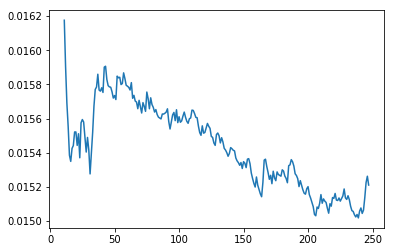

In [53]:
learn.sched.plot_loss()

In [54]:
learn.save(f'600urn-{S_PREFIX}')

In [427]:
learn.load(f'600urn-{S_PREFIX}')

In [428]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

TypeError: Invalid dimensions for image data

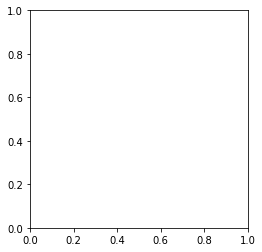

In [429]:
show_img(py[0]>0);

In [ ]:
show_img(y[0]);

## Save results

In [430]:
import sys, skvideo.io, json, base64
import numpy as np
from PIL import Image
from io import BytesIO, StringIO

In [435]:
m_base = get_base()
m = to_gpu(Unet34(m_base))

In [436]:
# model_summary(m, [3,608,800])

In [437]:
# learn.load('1024urn')
load_model(m, str(PATH/f'models/600urn-{S_PREFIX}.h5'))

In [434]:
# file = sys.argv[-1]
file = 'test_video.mp4'

if file == 'demo.py':
    print("Error loading video")
    quit

# Define encoder function
def encode(array):
    pil_img = Image.fromarray(array)
    buff = BytesIO()
    pil_img.save(buff, format="PNG")
    return base64.b64encode(buff.getvalue()).decode("utf-8")

video = skvideo.io.vread(file)

In [ ]:
# resized_video = np.array([scipy.misc.imresize(f, size=(512,512)) for f in video])

In [ ]:
def normalize(x):
    if np.mean(x) > 1:
        x = x/255
    m,s = imagenet_stats
    x = (x-m)/s
    return x
def preprocess(video):
    f1_norm = normalize(video)
    f1_roll = np.rollaxis(f1_norm, 3, 1)
    f1_pad = np.pad(f1_roll, [(0,0),(0,0),(0,8),(0,0)], mode='constant')
    return f1_pad

In [ ]:
f1 = preprocess(video)

In [ ]:
results = []
for i in range(0,f1.shape[0],8):
    xv = VV(torch.from_numpy(f1[i:i+8]).contiguous().float())
    preds = m(xv)
    mx,idx = torch.max(preds, 1)
    idx_slice = idx[:,:-8,:]
    results.append(idx_slice)

In [ ]:
r_stacked = torch.cat(results,0)
r_np = r_stacked.data.cpu().numpy()

In [ ]:
import matplotlib.pyplot as plt
def plot_res(index):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 15))
    f.tight_layout()
    ax1.imshow(video[index])
    ax2.imshow(r_np[index])

In [ ]:
plot_res(10)

In [ ]:
answer_key = {}

# Frame numbering starts at 1
frame_idx = 1
for frame in r_np:
    # Look for red cars :)
    binary_car_result = (frame==1).astype('uint8')
#     print(np.mean(binary_car_result))
    
    # Look for road :)
    binary_road_result = (frame==2).astype('uint8')

    answer_key[frame_idx] = [encode(binary_car_result), encode(binary_road_result)]
    
    # Increment frame
    frame_idx+=1

# Print output in proper json format
tester_data = json.dumps(answer_key)
with open('tester_data_multi_take2', 'w') as f:
    f.write(tester_data)
print(json.dumps(answer_key))

### Decoding car

In [ ]:
PATH

In [ ]:
from scipy import misc
def decode(packet):
	img = base64.b64decode(packet)
	filename = PATH/'image.png'
	with open(filename, 'wb') as f:
			f.write(img)
	result = misc.imread(filename)
	return result

with open('results.json') as json_data:
	ans_data = json.loads(json_data.read())
	json_data.close()

In [ ]:
def plot_ans(index):
    ans = decode(ans_data[str(index)][0])
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 15))
    f.tight_layout()
    ax1.imshow(r_np[index])
    ax1.set_title('Mine', fontsize=35)
    ax2.imshow(ans)
    ax2.set_title('Answer', fontsize=35)
    ax3.imshow(video[index])
    ax2.set_title('Original', fontsize=35)

In [ ]:
plot_ans(10)

In [ ]:
ans = decode(ans_data['1'][0])

In [ ]:
import matplotlib.pyplot as plt
def plot_res(index):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 15))
    f.tight_layout()